# iNethi Traffic Analysis

In [1]:
%reload_ext autoreload
%autoreload 2

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import calendar
from scipy.stats import describe
from scipy import stats

import seaborn as sns
#sns.set(style="ticks", palette="pastel")

plt.style.use('default')

def dataDescribe(df):
    
    df_mean = df.groupby(df.index).mean()
    df_median = df.groupby(df.index).median()
    df_std = df.groupby(df.index).std()
    df_sum = df.groupby(df.index).sum()
    
    months = df.index.unique()
    
    df_desc = pd.DataFrame(columns=['Month','Mean','Median','Std Dev','Variance','Skewness','Kurtosis','Min','Max','Sum'])
    for m in months:
        d = describe(df.loc[df.index==m], axis=0)
        median = df_median[df_median.index==m].bytes[0]
        std = df_std[df_std.index==m].bytes[0]
        total = df_sum[df_sum.index==m].bytes[0] 
        df_desc = df_desc.append({'Month':m,
                                            'Mean':d.mean[0],
                                            'Median': median,
                                            'Std Dev':std,
                                            'Variance': d.variance[0],
                                            'Skewness': d.skewness[0],
                                            'Kurtosis': d.kurtosis[0],
                                            'Min': d.minmax[0][0],
                                            'Max': d.minmax[1][0],
                                            'Sum': total
                                           } , ignore_index=True)

    return df_desc

def sumTraffic(df):
    df = df.groupby('date')['date','download_bytes', 'upload_bytes'].sum()
    df.index = pd.to_datetime(df.index, dayfirst=False, errors='coerce')
    df = df.resample('D').sum()
    df['download_bytes'] = df.apply(lambda x: x.download_bytes/1e+9, axis=1)
    df['upload_bytes'] = df.apply(lambda x: x.upload_bytes/1e+9, axis=1)
    df = df.reset_index()
    return df

def extractLocalTraffic(df):
    df_local = df.loc[df.dest_ip.str.startswith('10.2', na=False)]
    df_local = df_local.loc[df_local.src_ip.str.startswith('10.', na=False)]
    return df_local

def extractGlobalTraffic(df):
    df_global = df.loc[~(df.dest_ip.str.startswith('10.', na=False))]
    df_global = df_global.loc[df_global.src_ip.str.startswith('10.', na=False)]
    return df_global


## Overall Traffic stats Local vs Global
Traffic is coming from three main locations: mesh, school and servers. 

In [2]:
df_stats = pd.read_csv('data/stats/traffic_stats.csv', parse_dates=True)

In [3]:
df_stats_local = extractLocalTraffic(df_stats)
df_stats_global = extractGlobalTraffic(df_stats)

df_local = sumTraffic(df_stats_local)
df_global = sumTraffic(df_stats_global)

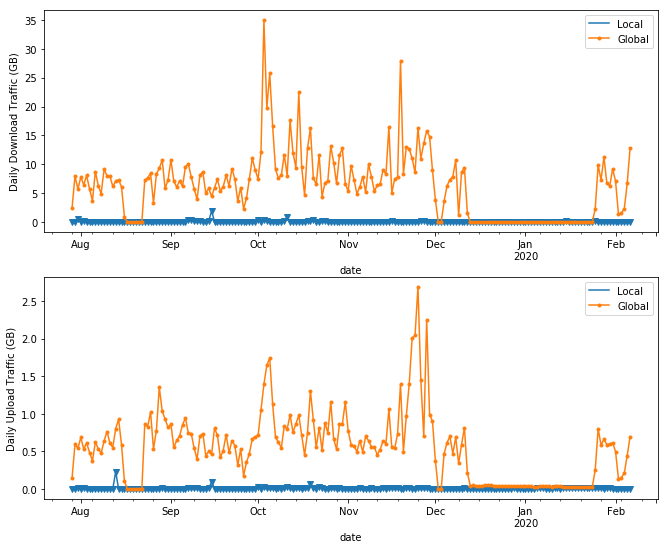

In [4]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(11, 9))

df_local.plot(ax=axes[0], x="date", y=["download_bytes"], kind="line", marker='v', linestyle='-', label=['Local'])
df_global.plot(ax=axes[0], x="date", y=["download_bytes"], kind="line", marker='.', linestyle='-', label=['Global'])
df_local.plot(ax=axes[1], x="date", y=["upload_bytes"], kind="line", marker='v', linestyle='-', label=['Local'])
df_global.plot(ax=axes[1], x="date", y=["upload_bytes"], kind="line", marker='.', linestyle='-', label=['Global'])

axes[0].set_ylabel('Daily Download Traffic (GB)')
axes[1].set_ylabel('Daily Upload Traffic (GB)')

plt.savefig('plots/daily_traffic_local_vs_global.pdf')
plt.show()

### Descriptive statistics of daily IP data upload traffic in GB

In [5]:
df_local['month'] = pd.DatetimeIndex(df_local.date).month
df_local['month'] = df_local['month'].apply(lambda x: calendar.month_abbr[x])
df_local = df_local.set_index('month')
df_global['month'] = pd.DatetimeIndex(df_global.date).month
df_global['month'] = df_global['month'].apply(lambda x: calendar.month_abbr[x])
df_global = df_global.set_index('month')

In [6]:
df_local_down = df_local.iloc[:,[1]].rename(columns={"download_bytes": "bytes"})
df_local_up = df_local.iloc[:,[2]].rename(columns={"upload_bytes": "bytes"})
df_global_down = df_global.iloc[:,[1]].rename(columns={"download_bytes": "bytes"})
df_global_up = df_global.iloc[:,[2]].rename(columns={"upload_bytes": "bytes"})

In [7]:
dataDescribe(df_local_down).set_index('Month').T

Month,Jul,Aug,Sep,Oct,Nov,Dec,Jan,Feb
Mean,0.184920,0.032416,0.158669,0.141686,0.078998,0.024036,0.031779,0.061483
Median,0.047762,0.017009,0.053027,0.088547,0.072451,0.006209,0.005994,0.063735
Std Dev,0.277729,0.047312,0.357833,0.164351,0.041068,0.030383,0.057722,0.028994
Variance,0.077133,0.002238,0.128044,0.027011,0.001687,0.000923,0.003332,0.000841
Skewness,0.685993,3.224887,4.503597,3.041101,1.606338,1.315272,2.822360,-0.051441
Kurtosis,-1.500000,11.970405,20.149060,9.986043,3.847195,0.679909,8.298107,-0.674333
Min,0.002453,0.000000,0.006033,0.027883,0.023798,0.000035,0.002620,0.018182
Max,0.504545,0.247744,1.964129,0.858507,0.228191,0.113698,0.272736,0.103923
Sum,0.554760,1.004910,4.760081,4.392274,2.369930,0.745130,0.985149,0.368900


In [8]:
dataDescribe(df_global_down).set_index('Month').T

Month,Jul,Aug,Sep,Oct,Nov,Dec,Jan,Feb
Mean,5.414289,5.587717,6.889304,11.989084,9.969498,1.958367,1.712020,5.320497
Median,5.709419,6.470791,6.688131,10.318482,8.466336,0.001867,0.001615,4.518388
Std Dev,2.769867,3.354649,2.149782,6.636013,4.841946,3.412469,3.475615,4.475607
Variance,7.672163,11.253668,4.621563,44.036669,23.444444,11.644946,12.079898,20.031055
Skewness,-0.193523,-0.685398,0.051615,1.708288,1.811013,1.454684,1.710007,0.721967
Kurtosis,-1.500000,-0.872936,-0.497279,3.100292,4.163027,0.544844,1.303680,-0.757140
Min,2.508674,0.000000,2.321926,4.427977,4.914230,0.000066,0.000321,1.385668
Max,8.024773,10.758572,11.078163,34.962554,27.825000,10.762577,11.278645,12.853774
Sum,16.242866,173.219235,206.679119,371.661601,299.084943,60.709384,53.072610,31.922984


### Boxplot of download traffic

In [9]:
df_local_down['type'] = "local"
df_global_down['type'] = "global"

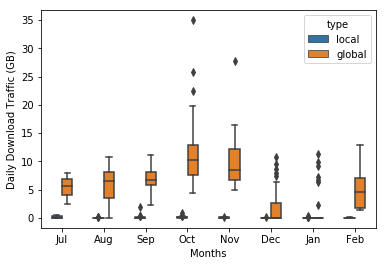

In [10]:
df_merged = pd.concat([df_local_down, df_global_down])

ax = sns.boxplot(y='bytes', x=df_merged.index, 
                 data=df_merged, 
                 #palette="colorblind",
                 hue='type', width=0.5)

ax.set(xlabel='Months', ylabel='Daily Download Traffic (GB)')
plt.savefig('plots/box_plot_traffic_local_vs_global.pdf')
plt.show()


### Daily traffic pattern - UDP vs TCP
#### Local Traffic

In [12]:
df_download = df_stats_local.iloc[:,[0,2,6]]
df_download = df_download.groupby(['date','protocol'])['download_bytes'].sum().reset_index()
df_download = df_download.pivot(index='date', columns='protocol', values='download_bytes').reset_index()
df_download.columns = ['date', 'tcp_down','udp_down']

df_upload = df_stats.iloc[:,[0,2,8]]
df_upload = df_upload.groupby(['date','protocol'])['upload_bytes'].sum().reset_index()
df_upload = df_upload.pivot(index='date', columns='protocol', values='upload_bytes').reset_index()
df_upload.columns = ['date', 'tcp_up','udp_up']

df_downup = df_upload.merge(df_download, left_on='date', right_on='date', suffixes=(False, False))
df_downup['download'] = df_downup.tcp_down + df_downup.udp_down
df_downup['upload'] = df_downup.tcp_up + df_downup.udp_up

df_downup.index = pd.to_datetime(df_downup.date, dayfirst=False) 
df_downup = df_downup.resample('D').sum()
df_downup = df_downup[['tcp_up', 'udp_up', 'tcp_down', 'udp_down', 'download', 'upload']].div(1e+9, axis=0)
df_downup_local = df_downup.reset_index()

#### Global

In [13]:
df_download = df_stats_global.iloc[:,[0,2,6]]
df_download = df_download.groupby(['date','protocol'])['download_bytes'].sum().reset_index()
df_download = df_download.pivot(index='date', columns='protocol', values='download_bytes').reset_index()
df_download.columns = ['date', 'tcp_down','udp_down']

df_upload = df_stats.iloc[:,[0,2,8]]
df_upload = df_upload.groupby(['date','protocol'])['upload_bytes'].sum().reset_index()
df_upload = df_upload.pivot(index='date', columns='protocol', values='upload_bytes').reset_index()
df_upload.columns = ['date', 'tcp_up','udp_up']

df_downup = df_upload.merge(df_download, left_on='date', right_on='date', suffixes=(False, False))
df_downup['download'] = df_downup.tcp_down + df_downup.udp_down
df_downup['upload'] = df_downup.tcp_up + df_downup.udp_up

df_downup.index = pd.to_datetime(df_downup.date, dayfirst=False) 
df_downup = df_downup.resample('D').sum()
df_downup = df_downup[['tcp_up', 'udp_up', 'tcp_down', 'udp_down', 'download', 'upload']].div(1e+9, axis=0)
df_downup_global = df_downup.reset_index()

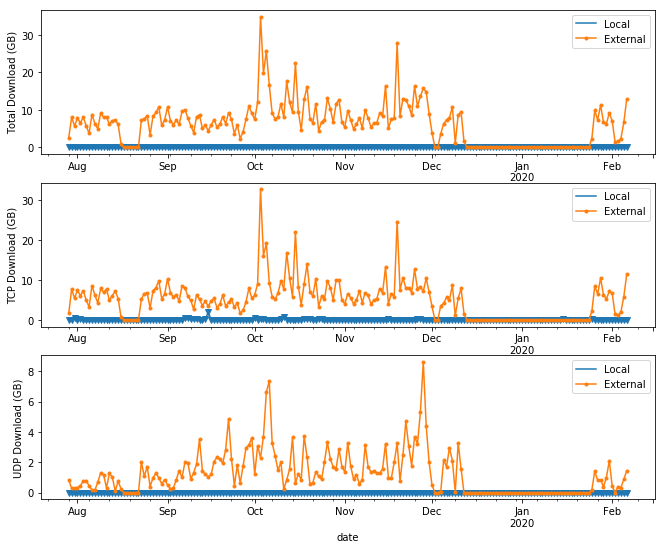

In [14]:
fig, axes = plt.subplots(nrows=3, ncols=1)

df_downup_local.plot(ax=axes[0], x="date", y=["download"], kind="line", marker='v', linestyle='-', figsize=(11, 9), label=['Local'])
df_downup_global.plot(ax=axes[0], x="date", y=["download"], kind="line", marker='.', linestyle='-', figsize=(11, 9), label=['External'])

df_downup_local.plot(ax=axes[1], x="date", y=["tcp_down"], kind="line", marker='v', linestyle='-', figsize=(11, 9), label=['Local'])
df_downup_global.plot(ax=axes[1], x="date", y=["tcp_down"], kind="line", marker='.', linestyle='-', figsize=(11, 9), label=['External'])

df_downup_local.plot(ax=axes[2], x="date", y=["udp_down"], kind="line", marker='v', linestyle='-', figsize=(11, 9), label=['Local'])
df_downup_global.plot(ax=axes[2], x="date", y=["udp_down"], kind="line", marker='.', linestyle='-', figsize=(11, 9), label=['External'])

axes[0].set_ylabel('Total Download (GB)')
axes[1].set_ylabel('TCP Download (GB)')
axes[2].set_ylabel('UDP Download (GB)')


plt.savefig('plots/daily_traffic_tcp_ucp.pdf')
plt.show()

### Split between mesh, school and servers
#### Local traffic

In [15]:
#df_stats_local = extractLocalTraffic(df_stats)
df_download1 = df_stats_local.iloc[:,[0,1,6]]
df_download1 = df_download1.groupby(['date','location'])['download_bytes'].sum().reset_index()
df_download1 = df_download1.pivot(index='date', columns='location', values='download_bytes').reset_index()
df_download1.columns = ['date', 'mesh_down','school_down', 'servers_down']

df_upload1 = df_stats_local.iloc[:,[0,1,8]]
df_upload1 = df_upload1.groupby(['date','location'])['upload_bytes'].sum().reset_index()
df_upload1 = df_upload1.pivot(index='date', columns='location', values='upload_bytes').reset_index()
df_upload1.columns = ['date', 'mesh_up','school_up', 'servers_up']

df_downup1 = df_upload1.merge(df_download1, left_on='date', right_on='date', suffixes=(False, False))
df_downup1['download'] = df_downup1.mesh_down + df_downup1.school_down + df_downup1.servers_down
df_downup1['upload'] = df_downup1.mesh_up + df_downup1.school_up + df_downup1.servers_up

df_downup1.index = pd.to_datetime(df_downup1.date, dayfirst=False) 
df_downup1 = df_downup1.resample('D').sum()
df_downup1 = df_downup1[['mesh_down', 'school_down', 'mesh_up', 'school_up','servers_down','servers_up','download','upload']].div(1e+9, axis=0)
df_downup1 = df_downup1.reset_index()

#### Global Traffic

In [16]:
df_download2 = df_stats_global.iloc[:,[0,1,6]]
df_download2 = df_download2.groupby(['date','location'])['download_bytes'].sum().reset_index()
df_download2 = df_download2.pivot(index='date', columns='location', values='download_bytes').reset_index()
df_download2.columns = ['date', 'mesh_down','school_down', 'servers_down']

df_upload2 = df_stats_global.iloc[:,[0,1,8]]
df_upload2 = df_upload2.groupby(['date','location'])['upload_bytes'].sum().reset_index()
df_upload2 = df_upload2.pivot(index='date', columns='location', values='upload_bytes').reset_index()
df_upload2.columns = ['date', 'mesh_up','school_up', 'servers_up']

df_downup2 = df_upload1.merge(df_download2, left_on='date', right_on='date', suffixes=(False, False))
df_downup2['download'] = df_downup2.mesh_down + df_downup2.school_down + df_downup2.servers_down
df_downup2['upload'] = df_downup2.mesh_up + df_downup2.school_up + df_downup2.servers_up

df_downup2.index = pd.to_datetime(df_downup2.date, dayfirst=False) 
df_downup2 = df_downup2.resample('D').sum()
df_downup2 = df_downup2[['mesh_down', 'school_down', 'mesh_up', 'school_up','servers_down','servers_up','download','upload']].div(1e+9, axis=0)
df_downup2 = df_downup2.reset_index()

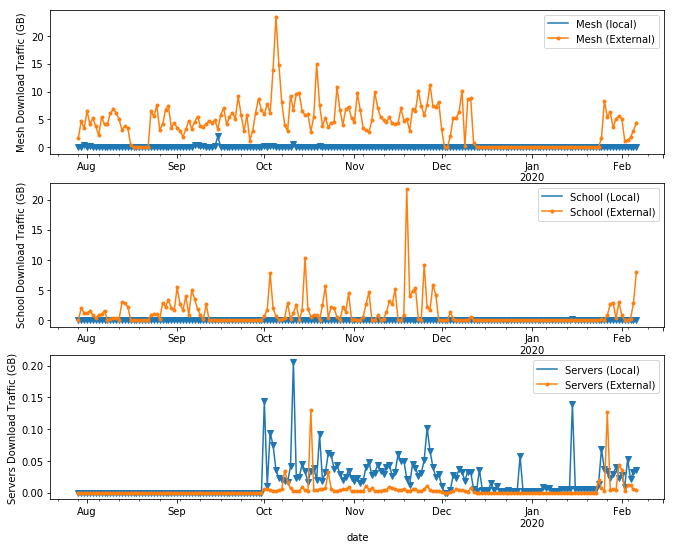

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=1)

df_downup1.plot(ax=axes[0], x="date", y=["mesh_down"], kind="line", marker='v', linestyle='-', figsize=(11, 9), label=['Mesh (local)'])
df_downup2.plot(ax=axes[0], x="date", y=["mesh_down"], kind="line", marker='.', linestyle='-', figsize=(11, 9), label=['Mesh (External)'])

df_downup1.plot(ax=axes[1], x="date", y=["school_down"], kind="line", marker='v', linestyle='-', figsize=(11, 9), label=['School (Local)'])
df_downup2.plot(ax=axes[1], x="date", y=["school_down"], kind="line", marker='.', linestyle='-', figsize=(11, 9), label=['School (External)'])

df_downup1.plot(ax=axes[2], x="date", y=["servers_down"], kind="line", marker='v', linestyle='-', figsize=(11, 9), label=['Servers (Local)'])
df_downup2.plot(ax=axes[2], x="date", y=["servers_down"], kind="line", marker='.', linestyle='-', figsize=(11, 9), label=['Servers (External)'])

axes[0].set_ylabel('Mesh Download Traffic (GB)')
axes[1].set_ylabel('School Download Traffic (GB)')
axes[2].set_ylabel('Servers Download Traffic (GB)')


plt.savefig('plots/daily_traffic_location.pdf')
plt.show()

#### Between October and December only

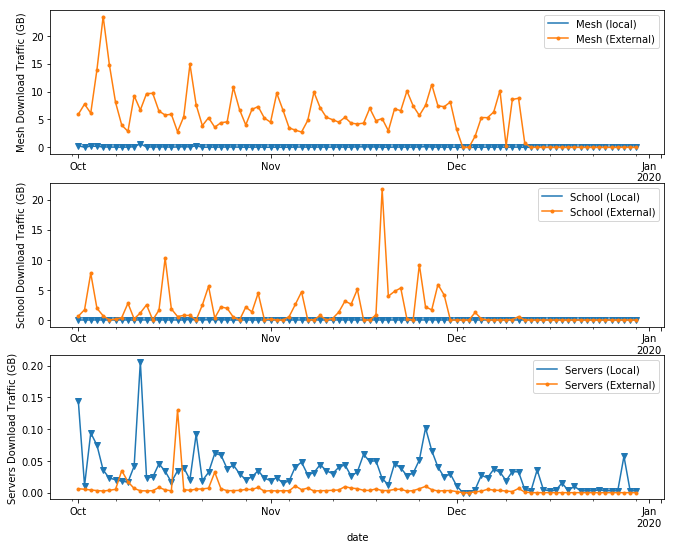

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=1)

mask1 = (df_downup1['date'] >= '2019-10-01') & (df_downup1['date'] < '2019-12-31')
mask2 = (df_downup2['date'] >= '2019-10-01') & (df_downup2['date'] < '2019-12-31')

df_downup1_oct_dec = df_downup1.loc[mask1]
df_downup2_oct_dec = df_downup2.loc[mask2]

df_downup1_oct_dec.plot(ax=axes[0], x="date", y=["mesh_down"], kind="line", marker='v', linestyle='-', figsize=(11, 9), label=['Mesh (local)'])
df_downup2_oct_dec.plot(ax=axes[0], x="date", y=["mesh_down"], kind="line", marker='.', linestyle='-', figsize=(11, 9), label=['Mesh (External)'])

df_downup1_oct_dec.plot(ax=axes[1], x="date", y=["school_down"], kind="line", marker='v', linestyle='-', figsize=(11, 9), label=['School (Local)'])
df_downup2_oct_dec.plot(ax=axes[1], x="date", y=["school_down"], kind="line", marker='.', linestyle='-', figsize=(11, 9), label=['School (External)'])

df_downup1_oct_dec.plot(ax=axes[2], x="date", y=["servers_down"], kind="line", marker='v', linestyle='-', figsize=(11, 9), label=['Servers (Local)'])
df_downup2_oct_dec.plot(ax=axes[2], x="date", y=["servers_down"], kind="line", marker='.', linestyle='-', figsize=(11, 9), label=['Servers (External)'])

axes[0].set_ylabel('Mesh Download Traffic (GB)')
axes[1].set_ylabel('School Download Traffic (GB)')
axes[2].set_ylabel('Servers Download Traffic (GB)')

plt.savefig('plots/daily_traffic_location_oct_dec.pdf')
plt.show()

### Scatterplot of download vs upload

In [22]:
df_local.head()

,date,download_bytes,upload_bytes
month,,,
Jul,2019-07-29,0.002453,0.000653
Jul,2019-07-30,0.047762,0.003499
Jul,2019-07-31,0.504545,0.014192
Aug,2019-08-01,0.070830,0.002474
Aug,2019-08-02,0.247744,0.007866


TypeError: scatter() got multiple values for argument 'x'

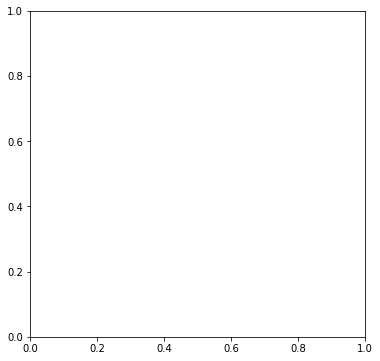

In [23]:
fig, ax = plt.subplots(figsize=(6,6))
df_global.plot.scatter(ax, x='download_bytes',y='upload_bytes', s=28, alpha=0.6)
plt.xlabel("Daily Download (GB)", labelpad=15)
plt.ylabel("Daily Upload (GB)", labelpad=15)
plt.title("Daily Download vs. Upload", y=1.015)

#plt.savefig("plots/scatter_download_vs_upload.pdf")
plt.show()


#### Pearson's Correlation Coefficient

In [ ]:
round(stats.pearsonr(df_total['download_bytes'], df_total['upload_bytes'])[0], 2)